<a href="https://colab.research.google.com/github/Roshan2002-prog/Acitve-Learning-Using-Gaussain-process/blob/main/Gaussian%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
import joblib

Loaded the Big Dataset using joblib. package that helps in importing the bigger type dataset unlike smaller ones.

In [ ]:
rf = joblib.load('ground_truth.sav')

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Now we will insert Noise in randomnes using log function so that our model will understand how much more accuracy it will need to work efficiently. Based on like estimation on disatnce.

In [ ]:
def give_noise(y_test,noise):
  y_test[:, 0] = np.exp(y_test[:, 0]*(1+np.log(1.03)*noise[:, 0]))
  y_test[:,1] = np.exp(y_test[:, 1]*(1+np.log(1.03)*noise[:, 1]))
  y_test[:, 2] = (1 + 0.02 * noise[:, 2] ) * y_test[:, 2]
  y_test[:, 3] = np.exp(y_test[:, 3]*(1+np.log(1.03)*noise[:, 3]))
  y_test[:, 4] = (1 + 0.02 * noise[:, 4] ) * y_test[:, 4]
  return y_test


We define the Ground truth model and then give its noise to the model so that we can predict accuracy.

In [ ]:
def ground_truth(x,rf,noise):
    y_test = rf.predict(x)
    y_test = give_noise(y_test,noise)
    return y_test

In [ ]:
train_input = np.load('train_input.npy')
train_output = np.load('train_output.npy')

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

bounds = np.array([[1000., 2000.], [0., 100.], [1000., 2000.], [200., 700.],
                   [-4., 6.], [1500., 3000.], [1500., 3500.], [40., 70.]])

In [ ]:
n_candidates = 5000
X_pool = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_candidates, bounds.shape[0]))

# Initialize training data
X_train = train_input.copy()
y_train = train_output.copy()

# Track model quality
model_quality = []

We add a kernel and WhiteKernel specially so that it helps us  model observation noise, essentially adding a constant variance

In [ ]:
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)) + WhiteKernel(noise_level=1e-2)

Now we use Active Learning to starating with 175 rounds so that eventually we can observe the improvement of the model overtime.

In [ ]:
# Active Learning Loop — FIXED!
for i in range(175):
    # Train model
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
    gp.fit(X_train, y_train)

    # Predict std dev on pool
    _, std = gp.predict(X_pool, return_std=True)
    max_point = np.argmax(std)

    # Get new data point from pool with max uncertainty
    x_new = X_pool[max_point].reshape(1, -1)
    noise = np.random.randn(1, 5)
    y_new = ground_truth(x_new, rf, noise)

    # Add to training set
    X_train = np.vstack((X_train, x_new))
    y_train = np.vstack((y_train, y_new))

    # Remove from pool
    X_pool = np.delete(X_pool, max_point, axis=0)

    # Evaluate on updated training set
    y_pred = gp.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))

    # ✅ Append RMSE to track model quality
    model_quality.append(rmse)

    # Log progress every 25 rounds
    if (i + 1) % 25 == 0:
        print(f"Round {i+1}: RMSE = {rmse:.4f}")

Round 25: RMSE = 6.1449
Round 50: RMSE = 4.4894
Round 75: RMSE = 1.8933
Round 100: RMSE = 1.9180
Round 125: RMSE = 2.3690
Round 150: RMSE = 2.4691
Round 175: RMSE = 0.7752


Total RMSE points collected: 176


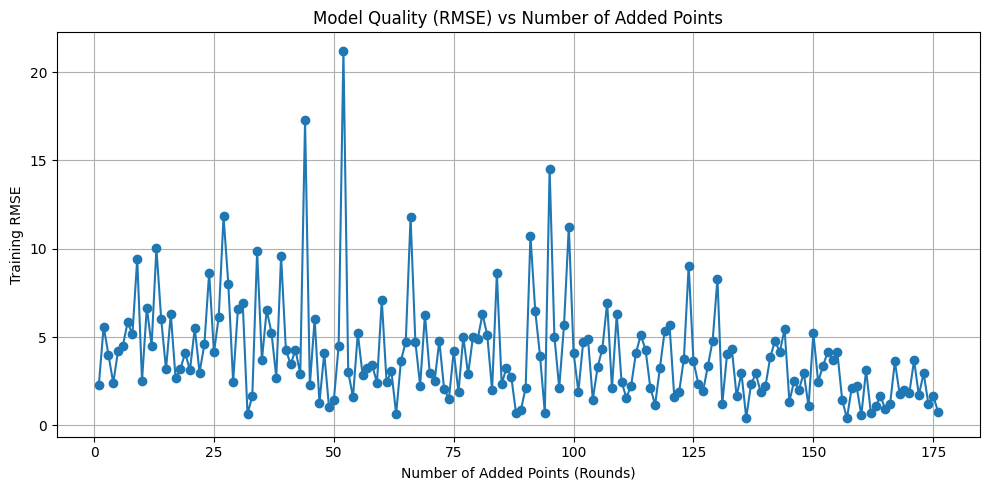

In [ ]:
print("Total RMSE points collected:", len(model_quality))  # Should be 175

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(model_quality) + 1), model_quality, marker='o', linestyle='-')
plt.title("Model Quality (RMSE) vs Number of Added Points")
plt.xlabel("Number of Added Points (Rounds)")
plt.ylabel("Training RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()